In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2024-07-31 02:11:07.063355: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# a = pd.read_pickle('iTransformer-TrafficL_new.pkl')
# a['iTransformer-TrafficL'] = a['iTransformer-M4']
# a.drop(['iTransformer-M4'], axis=1, inplace=True)
# a.to_pickle('iTransformer-TrafficL_new.pkl')


In [3]:


data_frames = []
data_frame = pd.read_pickle('LSTM_new.pkl')
data_frames.append(data_frame) 
for modelname in ['DilatedRNN_new', 'iTransformer-TrafficL_new', 'TFT_new', 'PatchTST-TrafficL_new']:
    filename = modelname + '.pkl'
    data_frame = pd.read_pickle(filename)
    modelname = modelname.replace('_new', '')
    data_frame = data_frame[modelname] 
    data_frames.append(data_frame)
    
df = pd.concat(data_frames, axis=1)
print("Data frames concatenated successfully.")
print(df)


# Function to calculate EMA for each group
def calculate_ema(group, span):
    return group.ewm(span=span, adjust=False).mean()

# Apply the function to each group for multiple spans
span_settings = [1, 2, 3, 4, 5, 10, 20]  # Example spans
for span in span_settings:
    print(f'EMA_{span}')
    df[f'EMA_{span}'] = df.groupby('unique_id')['y'].transform(lambda x: calculate_ema(x, span))
    df[f'EMA_{span}'] = df.groupby('unique_id')[f'EMA_{span}'].shift(1)

    
# Replace NaN values with 0
for span in span_settings:
    df[f'EMA_{span}'].fillna(0, inplace=True)
    
print(df)


Data frames concatenated successfully.
       unique_id         ds         y      LSTM  DilatedRNN  \
0          B1001 2005-03-15  0.000000  0.009109    0.013863   
1          B1001 2005-03-29  0.000000  0.008254    0.012851   
2          B1001 2005-04-12  0.000000  0.007836    0.012629   
3          B1001 2005-04-26  0.000000  0.007562    0.012499   
4          B1001 2005-05-10  0.000000  0.007309    0.012082   
...          ...        ...       ...       ...         ...   
249995      B994 2024-03-05  0.190756  0.156913    0.160091   
249996      B994 2024-03-19  0.184454  0.157441    0.160025   
249997      B994 2024-04-02  0.161021  0.158408    0.162135   
249998      B994 2024-04-16  0.149538  0.156644    0.160156   
249999      B994 2024-04-30  0.116601  0.154967    0.159252   

        iTransformer-TrafficL  iTransformer-M4       TFT  PatchTST-TrafficL  
0                    0.007599         0.024924  0.019391           0.012367  
1                    0.004505        -0.009633  

In [4]:
import numpy as np

# Ensure the data is sorted by unique_id and ds
df = df.sort_values(by=['unique_id', 'ds'])

# List of features to be used
features = [ 'TFT', 'iTransformer-TrafficL', 'LSTM', 'PatchTST-TrafficL', 'DilatedRNN']
test_length = 200
time_steps = 15
look_back = 6

# Initialize lists to hold the transformed data
train_data, train_targets, test_data, test_targets = [], [], [], []

# Iterate over each unique_id (time series)
for unique_id in df['unique_id'].unique():
    ts_data = df[df['unique_id'] == unique_id].reset_index(drop=True)
    ts_length = len(ts_data)
    split_point = ts_length - test_length

    # Prepare arrays for faster indexing
    feature_data = ts_data[features].values
    target_data = ts_data['y'].values

    def process_data(start, end, data_list, target_list):
        for i in range(start, end):
            past_features = feature_data[i-time_steps:i]
            look_backs = [target_data[i-time_steps-j:i-j].reshape(time_steps, 1) for j in range(1, look_back+1)]
            concatenated = np.hstack([past_features] + look_backs)
            data_list.append(concatenated)
            target_list.append(target_data[i-1])

    # Process training and testing data
    process_data(time_steps + look_back, split_point + 1, train_data, train_targets)
    process_data(split_point + 1, ts_length + 1, test_data, test_targets)

# Convert lists to numpy arrays
X_train, y_train = np.array(train_data), np.array(train_targets)
X_test, y_test = np.array(test_data), np.array(test_targets)

# Display shape information
print(f'Shape of X_train: {X_train.shape}')  # Expected: (number of training samples, time_steps, number of features)
print(f'Shape of y_train: {y_train.shape}')  # Expected: (number of training samples,)
print(f'Shape of X_test: {X_test.shape}')    # Expected: (number of test samples, time_steps, number of features)
print(f'Shape of y_test: {y_test.shape}')    # Expected: (number of test samples,)


Shape of X_train: (140000, 15, 11)
Shape of y_train: (140000,)
Shape of X_test: (100000, 15, 11)
Shape of y_test: (100000,)


GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-31 02:11:20.771156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30870 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


Epoch 1/50


2024-07-31 02:11:24.050399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-07-31 02:11:24.197000: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f81e710f0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-31 02:11:24.197029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-07-31 02:11:24.303048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 02:11:25.125884: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4363/4375 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 1 - Train Loss: 0.007234 - Test MSE: 0.006421
4375/4375 [==============================] - 25s 5ms/step - loss: 0.0072
Epoch 2/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0071
Epoch 2 - Train Loss: 0.007060 - Test MSE: 0.006382
4375/4375 [==============================] - 21s 5ms/step - loss: 0.0071
Epoch 3/50
4368/4375 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 3 - Train Loss: 0.007015 - Test MSE: 0.006375
4375/4375 [==============================] - 21s 5ms/step - loss: 0.0070
Epoch 4/50
4373/4375 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 4 - Train Loss: 0.006986 - Test MSE: 0.006346
4375/4375 [==============================] - 20s 5ms/step - loss: 0.0070
Epoch 5/50
4367/4375 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 5 - Train Loss: 0.006958 - Test MSE: 0.006315
4375/4375 [==============================] - 21s 5ms/step - loss

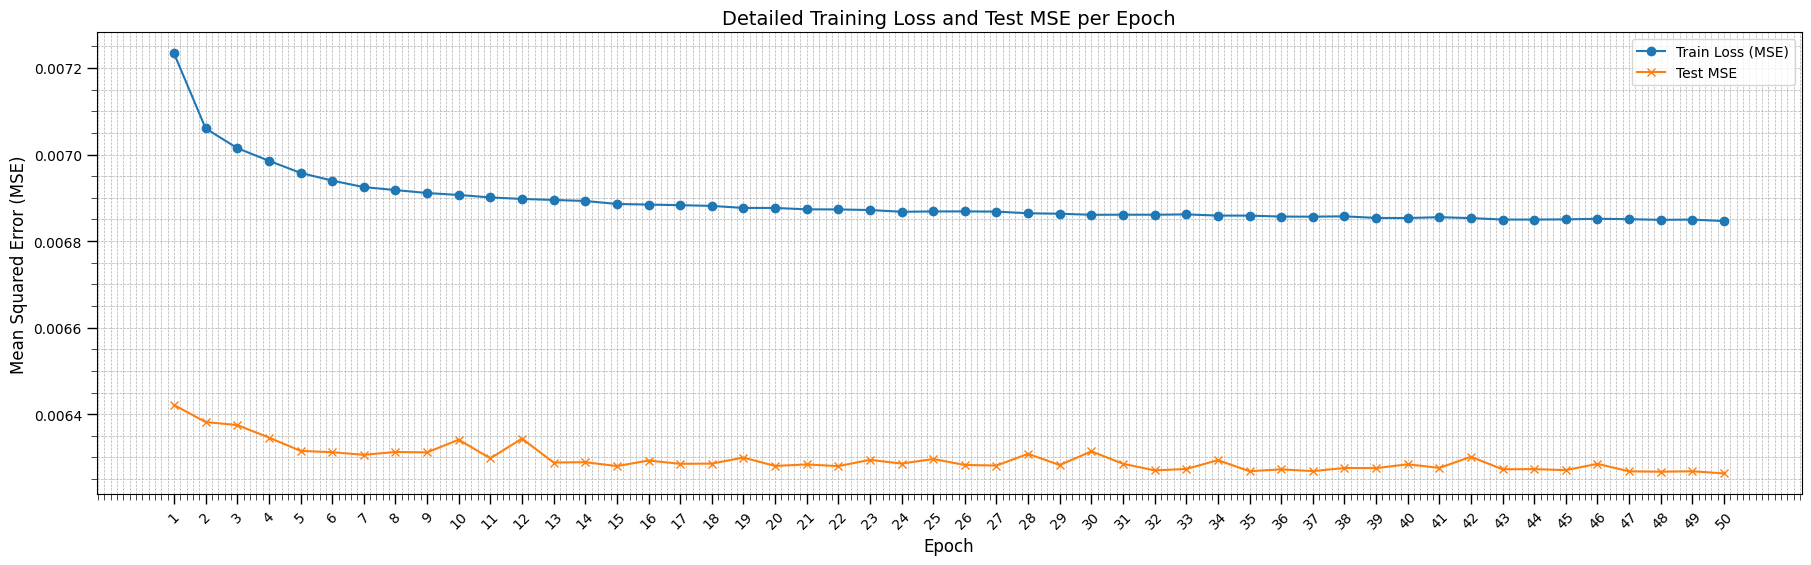

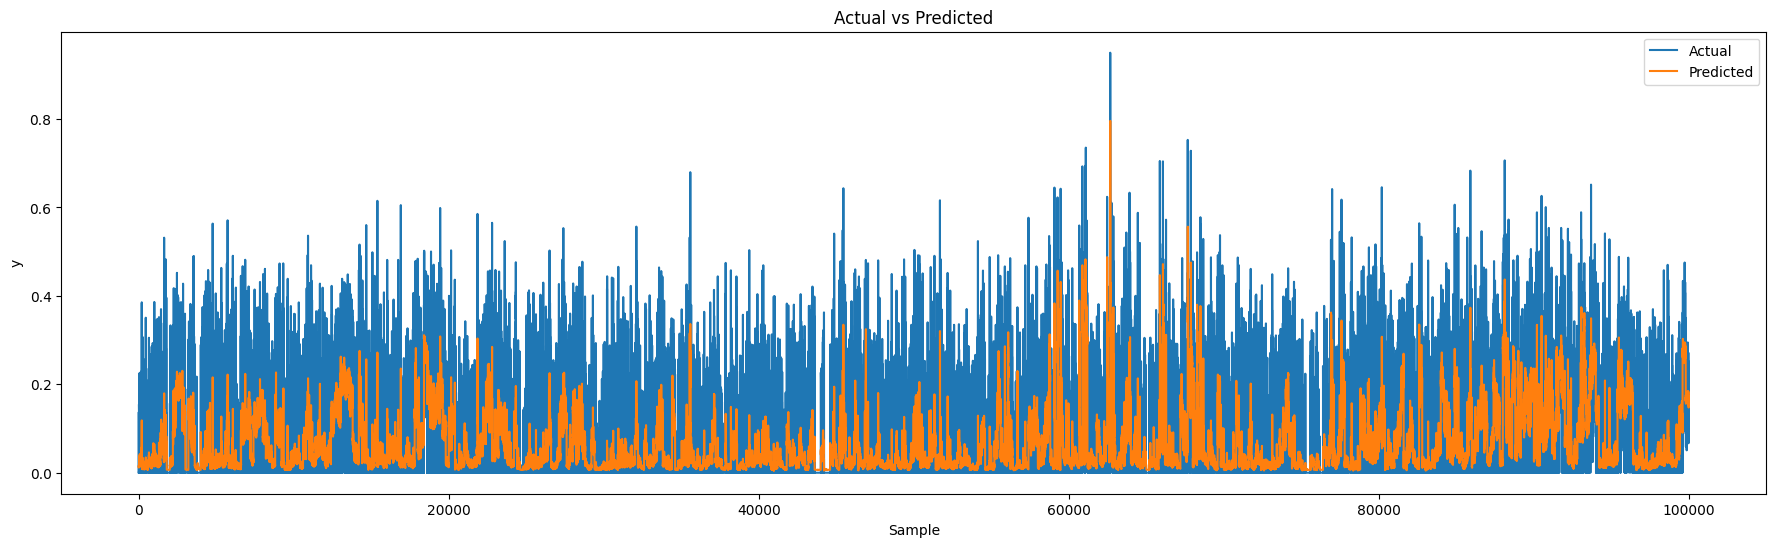

MSE:  0.0062632218601977475
MAE:  0.05141568382937662
NNSE1:  0.6173567470952459


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error
#-------------------------------------------------------------
# Set the seed for reproducibility
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
#-------------------------------------------------------------

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
else:
    print("No GPUs found. Running on CPU.")



# Define a custom callback to calculate MSE on the test set after each epoch
class TestMSECallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.train_losses = []
        self.test_mses = []
    
    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        y_pred = self.model.predict(X_test, verbose=0)
        mse = mean_squared_error(y_test, y_pred)
        train_loss = logs['loss']
        self.train_losses.append(train_loss)
        self.test_mses.append(mse)
        print(f'\nEpoch {epoch + 1} - Train Loss: {train_loss:.6f} - Test MSE: {mse:.6f}')

# Build the LSTM model with MLP layers at the beginning and the end
model = Sequential()
# MLP layer at the beginning
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# LSTM layers
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
# MLP layer at the end
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

# Create an instance of the custom callback
test_mse_callback = TestMSECallback(test_data=(X_test, y_test))

epoch = 50
# Train the model with the custom callback
history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.0, verbose=1, callbacks=[test_mse_callback])

# Make predictions
y_pred = model.predict(X_test)

# Print the final test MSE
final_mse = mean_squared_error(y_test, y_pred)
print(f'Final Test MSE: {final_mse:.6f}')

# Plot the training loss and test MSE
plt.figure(figsize=(22, 6))
plt.plot(range(1, epoch+1), test_mse_callback.train_losses, label='Train Loss (MSE)', marker='o')
plt.plot(range(1, epoch+1), test_mse_callback.test_mses, label='Test MSE', marker='x')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Detailed Training Loss and Test MSE per Epoch', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Adding more ticks for detailed information
plt.xticks(ticks=range(1, epoch+1), fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', length=7, width=1)
plt.tick_params(axis='both', which='minor', length=4, width=0.5)
plt.show()






# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('y')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - np.sum (np.square(y_true - y_pred) ) / np.sum( np.square(y_true - np.mean(y_true)) )
    return 1 / ( 2 - NSE)

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

Y_ACTUAL = y_test.reshape(500, test_length)
Y_HAT = y_pred.reshape(500, test_length)

MAE = mean_absolute_error(Y_ACTUAL, Y_HAT)
MSE = mean_squared_error(Y_ACTUAL, Y_HAT)
NNSE = normalized_nash_sutcliffe_efficiencySTavg(Y_ACTUAL, Y_HAT)


print("MSE: ", MSE)
print("MAE: ", MAE)
print("NNSE1: ", NNSE)



In [ ]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def normalized_nash_sutcliffe_efficiencySTavg(y_true, y_pred): # axis 0 space 1 time
    NSE = 1 - np.sum (np.square(y_true - y_pred) ) / np.sum( np.square(y_true - np.mean(y_true)) )
    return 1 / ( 2 - NSE)

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

Y_ACTUAL = y_test.reshape(500, test_length)
Y_HAT = y_pred.reshape(500, test_length)

MAE = mean_absolute_error(Y_ACTUAL*7.5, Y_HAT*7.5)
MSE = mean_squared_error(Y_ACTUAL*7.5, Y_HAT*7.5)
NNSE = normalized_nash_sutcliffe_efficiencySTavg(Y_ACTUAL*7.5, Y_HAT*7.5)


print("MSE: ", MSE)
print("MAE: ", MAE)
print("NNSE1: ", NNSE)